In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from tqdm import tqdm

import time
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/My Drive/cs5242-project
!pwd
import utils

/content/drive/My Drive/cs5242-project
/content/drive/My Drive/cs5242-project


# Preparing the Data

In [3]:
# Looking into the directory
data_dir = './dataset'
print(os.listdir(data_dir))
classes_train = os.listdir(data_dir + "/train")
classes_valid = os.listdir(data_dir + "/validation")
print(f'Train Classes - {classes_train}')
print(f'Validation Classes - {classes_valid}')

['train', 'validation']
Train Classes - ['disgusted', 'happy', 'neutral', 'surprised', 'scared', 'sad', 'angry']
Validation Classes - ['surprised', 'disgusted', 'neutral', 'angry', 'sad', 'scared', 'happy']


In [4]:
# Data transforms (Gray Scaling & data augmentation)
train_tfms = tt.Compose([tt.Grayscale(num_output_channels=1),
                         tt.RandomHorizontalFlip(),
                         tt.RandomRotation(30),
#                          tt.Resize((48,48)),
                         tt.ToTensor()])

valid_tfms = tt.Compose([tt.Grayscale(num_output_channels=1), tt.ToTensor()])

In [5]:
# Emotion Detection datasets
train_ds = ImageFolder(data_dir + '/train', train_tfms)
valid_ds = ImageFolder(data_dir + '/validation', valid_tfms)

In [6]:
batch_size = 200

In [7]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, num_workers=2, pin_memory=True)

Feature batch shape: torch.Size([200, 1, 128, 128])
Labels batch shape: torch.Size([200])


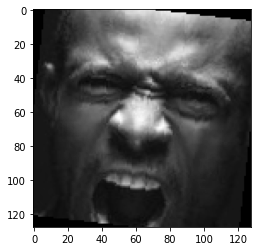

Label: 0


In [8]:
# Display image and label.
train_features, train_labels = next(iter(train_dl))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [9]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

torch.Size([1, 128, 128])


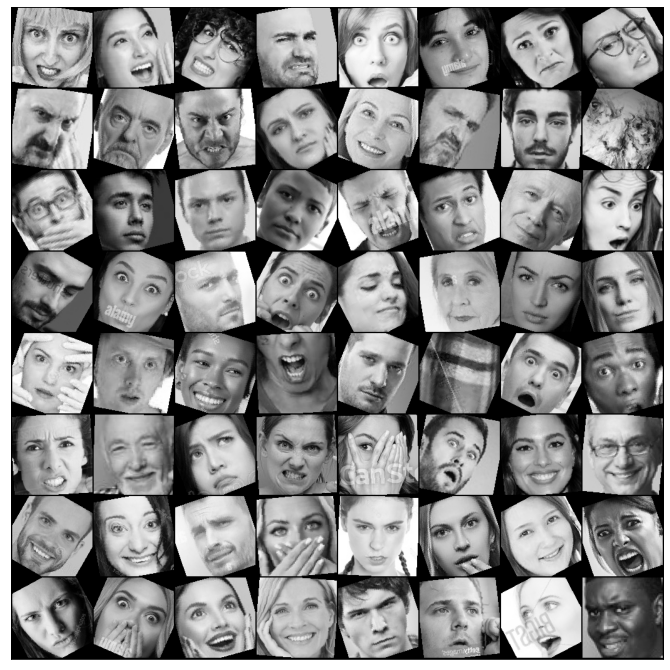

In [10]:
show_batch(train_dl)

In [12]:
device= torch.device("cuda")
#device= torch.device("cpu")
print(device)

cuda


# Make a Three layer net class

In [11]:
class three_layer_net(nn.Module):

    def __init__(self, input_size, hidden_size1, hidden_size2,  output_size):
        super(three_layer_net , self).__init__()

        self.layer1 = nn.Linear(  input_size   , hidden_size1  , bias=False  )
        self.layer2 = nn.Linear(  hidden_size1 , hidden_size2  , bias=False  )
        self.layer3 = nn.Linear(  hidden_size2 , output_size   , bias=False  )        
        
    def forward(self, x):
        
        y       = self.layer1(x)
        y_hat   = F.relu(y)
        z       = self.layer2(y_hat)
        z_hat   = F.relu(z)
        scores  = self.layer3(z_hat)
        
        return scores

# Build the net with the following size:

In [13]:
net=three_layer_net(128*128,500,500,7)
print(net)
utils.display_num_param(net)

three_layer_net(
  (layer1): Linear(in_features=16384, out_features=500, bias=False)
  (layer2): Linear(in_features=500, out_features=500, bias=False)
  (layer3): Linear(in_features=500, out_features=7, bias=False)
)
There are 8445500 (8.45 million) parameters in this neural network


# Send the weights of the networks to the GPU

In [14]:
net = net.to(device)

# Choose the criterion and optimizer

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer=torch.optim.SGD( net.parameters() , lr=0.01 )

# Function to evaluate the network on the test set

In [16]:
def eval_on_test_set():

    running_error=0
    num_batches=0

    for minibatch_data, minibatch_label in valid_dl:
        # send them to the gpu
        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)

        # reshape the minibatch
        inputs = minibatch_data.view(-1,128*128)

        # feed it to the network
        scores=net( inputs ) 

        # compute the error made on this batch
        error = utils.get_error( scores , minibatch_label)

        # add it to the running error
        running_error += error.item()

        num_batches+=1


    # compute error rate on the full test set
    total_error = running_error/num_batches

    print( 'error rate on test set =', total_error*100 ,'percent')

# Do 200 passes through the training set

In [17]:
start=time.time()

for epoch in range(200):
    
    running_loss=0
    running_error=0
    num_batches=0
 
    for minibatch_data, minibatch_label in train_dl:
    
        # Set the gradients to zeros
        optimizer.zero_grad()
        # send them to the gpu
        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
        
        # reshape the minibatch
        inputs = minibatch_data.view(-1, 128*128)

        # tell Pytorch to start tracking all operations that will be done on "inputs"
        inputs.requires_grad_()

        # forward the minibatch through the net 
        scores=net( inputs ) 

        # Compute the average of the losses of the data points in the minibatch
        loss =  criterion( scores , minibatch_label) 
        
        # backward pass to compute dL/dU, dL/dV and dL/dW   
        loss.backward()

        # do one step of stochastic gradient descent: U=U-lr(dL/dU), V=V-lr(dL/dU), ...
        optimizer.step()
        

        # START COMPUTING STATS
        
        # add the loss of this batch to the running loss
        running_loss += loss.detach().item()
        
        # compute the error made on this batch and add it to the running error       
        error = utils.get_error( scores.detach() , minibatch_label)
        running_error += error.item()
        
        num_batches+=1        
    
    
    # compute stats for the full training set
    total_loss = running_loss/num_batches
    total_error = running_error/num_batches
    elapsed = time.time()-start
    
    if epoch%5 == 0:
        print('epoch=',epoch, '\t time=', elapsed, '\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
        eval_on_test_set() 
        print(' ')
    

epoch= 0 	 time= 35.79792070388794 	 loss= 1.9354026985168458 	 error= 81.2400004863739 percent
error rate on test set = 82.74747530619302 percent
 
epoch= 5 	 time= 139.3064923286438 	 loss= 1.92148024559021 	 error= 79.39999985694885 percent
error rate on test set = 77.85353461901346 percent
 
epoch= 10 	 time= 184.2763020992279 	 loss= 1.904548625946045 	 error= 77.3800003528595 percent
error rate on test set = 71.82323137919107 percent
 
epoch= 15 	 time= 229.03425335884094 	 loss= 1.8918089962005615 	 error= 76.28000044822693 percent
error rate on test set = 72.05555240313211 percent
 
epoch= 20 	 time= 274.21254897117615 	 loss= 1.8771721839904785 	 error= 75.40000057220459 percent
error rate on test set = 75.9494960308075 percent
 
epoch= 25 	 time= 318.84446692466736 	 loss= 1.8630629777908325 	 error= 74.20000123977661 percent
error rate on test set = 78.63131165504456 percent
 
epoch= 30 	 time= 363.83401823043823 	 loss= 1.8456353807449342 	 error= 74.18000054359436 percent


# Save the model

torch.save(net.state_dict(), 'trained_models/mlp.pt')